# Matching Clusters Across Induction and Collection

In [2]:
import sys
sys.path.append('..')

import uproot
import numpy as np
import pandas as pd
import seaborn as sns
import awkward as ak 
import matplotlib.pyplot as plt

from lariat import Event
from matplotlib.patches import Rectangle

In [3]:
allclusters = pd.read_pickle("/Users/user/data/research/proton-deuteron/csv/allclusters.pkl") # deuterons from within vertices bounding box + one track protons
print(allclusters.columns); allclusters.shape

Index(['event_idx', 'run', 'subrun', 'event', 'file_path', 'event_index',
       'particle_type', 'plane', 'cluster_idx', 'area', 'max_intensity',
       'min_intensity', 'mean_intensity', 'total_intensity', 'centroid_x',
       'centroid_y', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row',
       'bbox_max_col', 'width', 'height', 'aspect_ratio', 'compactness',
       'image_intensity', 'matrix_transformed', 'column_maxes'],
      dtype='object')


(438575, 27)

In [4]:
# CUTS
print(allclusters.shape)
greaterThanThree = allclusters[allclusters['height'] > 3]; print(greaterThanThree.shape) # Remove all clusters with length = 1, noise
noConstants = greaterThanThree[greaterThanThree['column_maxes'].map(lambda x: len(set(x)) > 1)]; print(noConstants.shape) # Remove all clusters where the max ADC for each wire is the same (no change in energy deposition)

(438575, 27)
(105907, 27)
(105896, 27)


In [5]:
maxes = noConstants['column_maxes'].values

normalised = []

for i, signal in enumerate(maxes):
    
    minimum = 0
    maximum = np.max(signal)

    if maximum > minimum:
        normalised_signal = (signal - minimum) / (maximum - minimum)
    else:
        normalised_signal = np.zeros_like(signal, dtype=float)
        print(f'Error: Max not greater than min in signal {i}.')

    normalised.append(normalised_signal)

noConstants['normalised'] = normalised
adcdiff = [np.diff(signal) for signal in normalised]; noConstants['adcdiff'] = adcdiff
maxdiff = [np.max(diff) for diff in adcdiff]; noConstants['maxdiff'] = maxdiff

/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_47244/1492737920.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noConstants['normalised'] = normalised
/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_47244/1492737920.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adcdiff = [np.diff(signal) for signal in normalised]; noConstants['adcdiff'] = adcdiff
/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_47244/1492737920.py:20: SettingWithCopyWarning: 
A value is trying to

In [6]:
# CUTS
onlyPositiveDiff = noConstants[noConstants['maxdiff'] >= 0].reset_index(drop=True); print(onlyPositiveDiff.shape) # Remove all clusters with only negative change in energy deposition
lessThan180 = onlyPositiveDiff[onlyPositiveDiff['height'] < 180]; print(lessThan180.shape) # Remove all clusters wit length in wire greater than 180 - muons, noise

(105441, 30)
(91658, 30)


In [7]:
collection = (
    (lessThan180['plane'] == 'collection') &
    (lessThan180['max_intensity'] >= 100)
)

# Cuts for induction plane (adjust values as needed)
induction = (
    (lessThan180['plane'] == 'induction') &
    (lessThan180['max_intensity'] >= 50)
)

ADCcut = lessThan180[collection | induction]; print(ADCcut.shape) # Remove all clusters with max ADC less than 200, noise

(77721, 30)


In [8]:
# Bounding Box in Each Plane Cuts

collection = (
    (ADCcut['plane'] == 'collection') &
    (ADCcut['bbox_min_row'] > 12) & (ADCcut['bbox_min_row'] < 37) &
    (ADCcut['bbox_max_col'] > 789) & (ADCcut['bbox_max_col'] < 1927)
)

# Cuts for induction plane (adjust values as needed)
induction = (
    (ADCcut['plane'] == 'induction') &
    (ADCcut['bbox_min_row'] > 11) & (ADCcut['bbox_min_row'] < 35) &
    (ADCcut['bbox_max_col'] > 786) & (ADCcut['bbox_max_col'] < 1794)
)

# Combine both cuts
bboxCut = ADCcut[collection | induction].reset_index(drop=True); print(bboxCut.shape)

(26813, 30)


# DATA FOR SSVD

In [9]:
import os

HANDPICKED = '/Users/user/data/research/proton-deuteron/trainingdeuteronsindex'

numbers = []

for filename in os.listdir(HANDPICKED):
    if filename.endswith('.png'):
        try:
            number = int(filename.split('.')[0])
            numbers.append(number)
        except ValueError:
            pass

numbers.sort()

# print(numbers)
print('Number of handpicked deuterons', len(numbers))

#l5 = bboxCut[bboxCut['height'] < 15].reset_index(drop=True); print('Less that 15 shape:', len(l5))

l5 = pd.read_pickle('/Users/user/data/research/proton-deuteron/csv/l5.pkl'); print('Less that 15 shape:', len(l5))

handpicked_d = l5.loc[numbers].reset_index(drop=True)

deuteron_candidates = bboxCut[(bboxCut['particle_type'] == 'deuteron') & (bboxCut['plane'] == 'collection')]; print('All clean candidates', deuteron_candidates.shape)

columns_to_check = ['run', 'subrun', 'event']

duplicates = pd.merge(deuteron_candidates, handpicked_d, on=columns_to_check, how='inner')

deuteron_candidates = deuteron_candidates[~deuteron_candidates[columns_to_check].apply(tuple, axis=1).isin(duplicates[columns_to_check].apply(tuple, axis=1))]

print('Final shape after removing handpicked from candidates:', deuteron_candidates.shape)
print('Removed duplicates:', 4926-4544)

# deuteron_candidates.to_pickle('/Users/user/data/research/proton-deuteron/csv/deuteron_candidates.pkl')

Number of handpicked deuterons 516
Less that 15 shape: 843
All clean candidates (4926, 30)
Final shape after removing handpicked from candidates: (4373, 30)
Removed duplicates: 382


<Axes: >

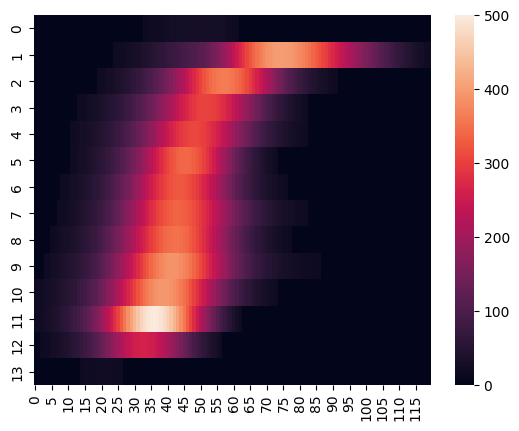

In [10]:
sns.heatmap(handpicked_d['image_intensity'][0])

Text(0.5, 1.0, 'Training Height')

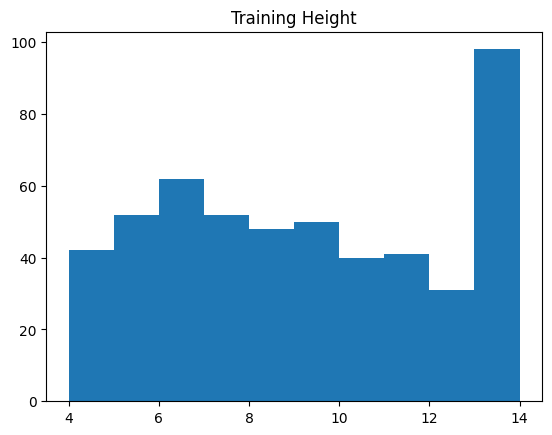

In [11]:
plt.hist(handpicked_d['height'], bins='auto')
plt.title('Training Height')

Text(0.5, 1.0, 'Training Width')

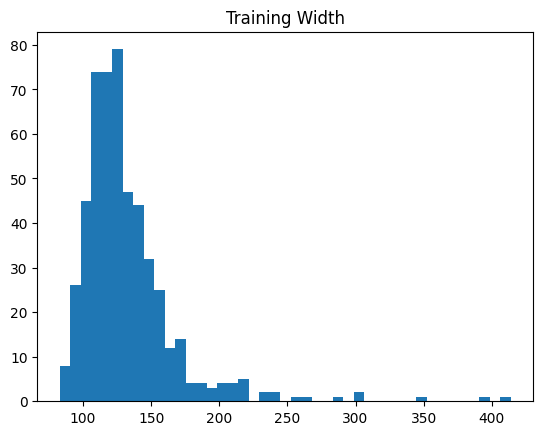

In [12]:
plt.hist(handpicked_d['width'], bins='auto')
plt.title('Training Width')

Text(0.5, 1.0, 'Inference Height')

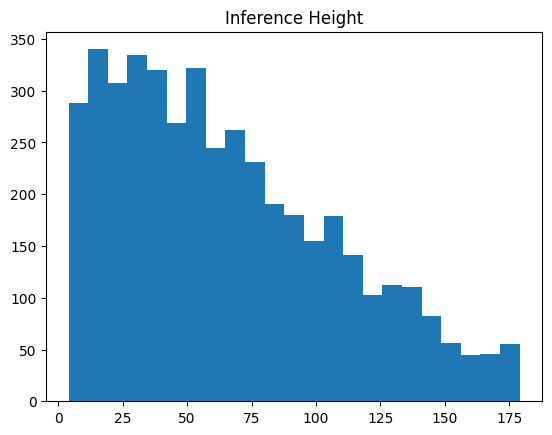

In [13]:
plt.hist(deuteron_candidates['height'], bins='auto')
plt.title('Inference Height')

Text(0.5, 1.0, 'Inference Width')

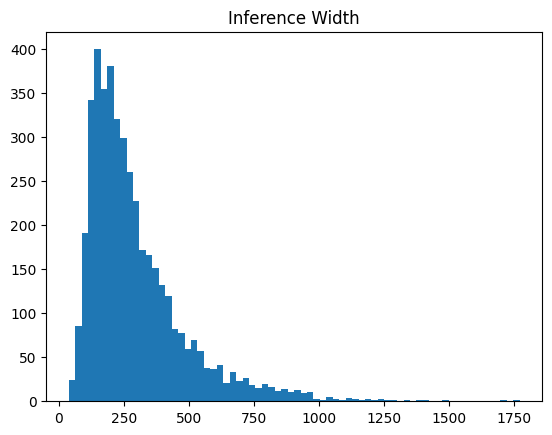

In [14]:
plt.hist(deuteron_candidates['width'], bins='auto')
plt.title('Inference Width')

In [15]:
a = deuteron_candidates[deuteron_candidates['height']>1]
max(a['height'])

179

<Axes: >

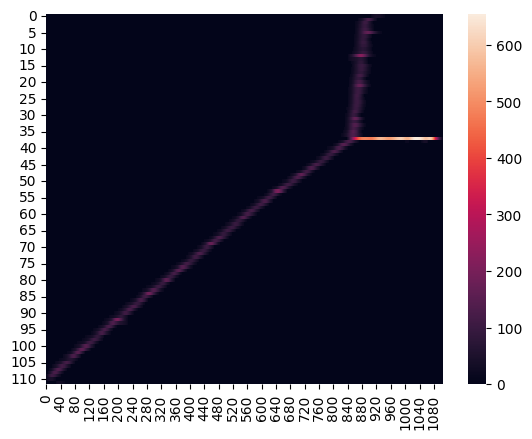

In [16]:
a = deuteron_candidates[deuteron_candidates['width'] > 1000].sample(n=1)
sns.heatmap(a['image_intensity'].iloc[0])

In [17]:
bboxCut.columns

Index(['event_idx', 'run', 'subrun', 'event', 'file_path', 'event_index',
       'particle_type', 'plane', 'cluster_idx', 'area', 'max_intensity',
       'min_intensity', 'mean_intensity', 'total_intensity', 'centroid_x',
       'centroid_y', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row',
       'bbox_max_col', 'width', 'height', 'aspect_ratio', 'compactness',
       'image_intensity', 'matrix_transformed', 'column_maxes', 'normalised',
       'adcdiff', 'maxdiff'],
      dtype='object')

In [18]:
events = bboxCut.groupby(['run', 'subrun', 'event']).size().reset_index(name='count')
event_counts = events['count'].value_counts()
event_counts

count
2     11362
1      1138
3       556
4       194
5        55
6        15
8         7
7         4
9         4
12        1
10        1
Name: count, dtype: int64

In [19]:
events

,run,subrun,event,count
0,8557,4,473,2
1,8557,7,596,2
2,8557,9,700,2
3,8557,10,734,2
4,8557,16,995,2
...,...,...,...,...
13332,9788,299,26208,2
13333,9788,305,26707,2
13334,9788,308,26943,2
13335,9788,311,27203,2


In [20]:
grouped = bboxCut.groupby(['run', 'subrun', 'event'])
grouped = grouped.apply(lambda x: x.reset_index(drop=True))
grouped

/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_47244/2125964331.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = grouped.apply(lambda x: x.reset_index(drop=True))


event_idx   run  subrun  event  \
run  subrun event                                     
8557 4      473   0        837  8557       4    473   
                  1        837  8557       4    473   
     7      596   0          0  8557       7    596   
                  1          0  8557       7    596   
     9      700   0          1  8557       9    700   
...                        ...   ...     ...    ...   
9788 308    26943 1       7634  9788     308  26943   
     311    27203 0       3941  9788     311  27203   
                  1       3941  9788     311  27203   
            27225 0       7635  9788     311  27225   
                  1       7635  9788     311  27225   

                                                             file_path  \
run  subrun event                                                        
8557 4      473   0  /Users/user/data/research/proton-deuteron/rawd...   
                  1  /Users/user/data/research/proton-deuteron/rawd...   
     7      596   0  /Users/user/data/research/proton-deuteron/rawp...   
                  1  /Users/user/data/research/proton-deuteron/rawp...   
     9      700   0  /Users/user/data/research/proton-deuteron/rawp...   
...                                                                ...   
9788 308    26943 1  /Users/user/data/research/proton-deuteron/rawp...   
     311    27203 0  /Users/user/data/research/proton-deuteron/rawd...   
                  1  /Users/user/data/research/proton-deuteron/rawd...   
            27225 0  /Users/user/data/research/proton-deuteron/rawp...   
                  1  /Users/user/data/research/proton-deuteron/rawp...   

                     event_index particle_type       plane  cluster_idx  \
run  subrun event                                                         
8557 4      473   0            0      deuteron  collection            0   
                  1            0      deuteron   induction            0   
     7      596   0            0        proton  collection            0   
                  1            0        proton   induction            0   
     9      700   0            0        proton  collection            0   
...                          ...           ...         ...          ...   
9788 308    26943 1            0        proton   induction            0   
     311    27203 0            0      deuteron  collection            0   
                  1            0      deuteron   induction            4   
            27225 0            0        proton  collection            1   
                  1            0        proton   induction            0   

                       area  ...  width  height  aspect_ratio  compactness  \
run  subrun event            ...                                             
8557 4      473   0   615.0  ...    166       8     20.750000     0.463102   
                  1   334.0  ...    139       5     27.800000     0.480576   
     7      596   0  6161.0  ...    642      93      6.903226     0.103189   
                  1  3352.0  ...    614      94      6.531915     0.058077   
     9      700   0  3880.0  ...    178      57      3.122807     0.382417   
...                     ...  ...    ...     ...           ...          ...   
9788 308    26943 1  1359.0  ...    106      47      2.255319     0.272782   
     311    27203 0  1413.0  ...    128      24      5.333333     0.459961   
                  1   718.0  ...     74      24      3.083333     0.404279   
            27225 0  3298.0  ...    167      58      2.879310     0.340491   
                  1  1559.0  ...    138      56      2.464286     0.201734   

                                                       image_intensity  \
run  subrun event                                                        
8557 4      473   0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                  1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
     7      596   0  [[-0.0, -0.0, -0.0, -0.0, -0.0, -0

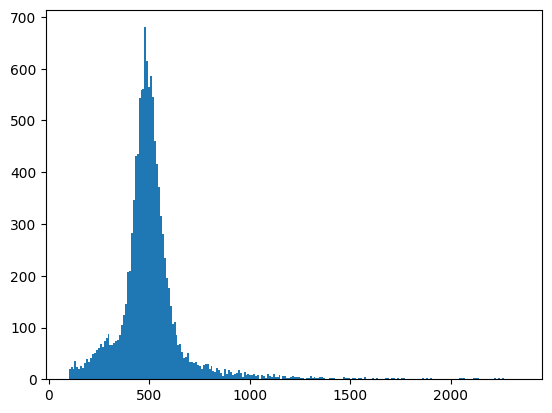

In [21]:
%matplotlib inline
plt.hist(grouped[grouped['plane'] == 'collection']['max_intensity'], bins='auto'); 
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

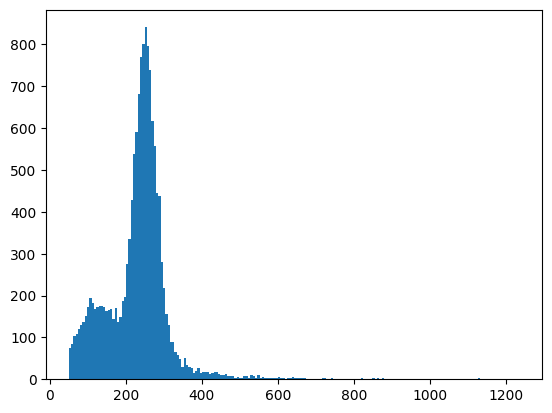

In [22]:
plt.hist(grouped[grouped['plane'] == 'induction']['max_intensity'], bins='auto'); plt.show

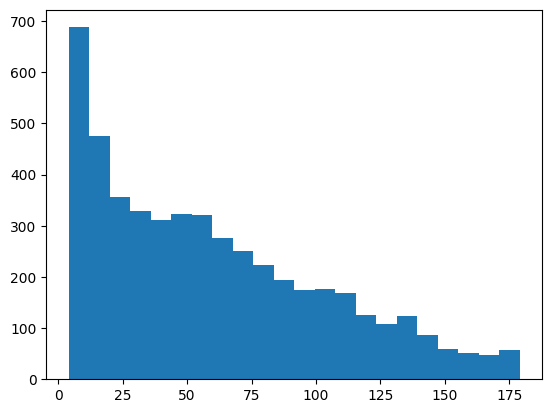

In [23]:
plt.hist(grouped[(grouped['plane'] == 'collection') & (grouped['particle_type'] == 'deuteron')]['height'], bins='auto'); 
plt.show()

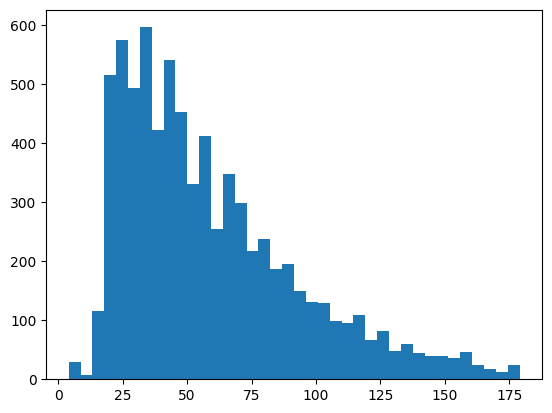

In [24]:
plt.hist(grouped[(grouped['plane'] == 'collection') & (grouped['particle_type'] == 'proton')]['height'], bins='auto'); 
plt.show()

In [130]:
two = events[events['count'] == 2]

In [131]:
two = pd.merge(bboxCut,
               two, 
               on=['run', 'subrun', 'event'], 
               how='inner')
two.shape

(22724, 31)

In [132]:
two.columns

Index(['event_idx', 'run', 'subrun', 'event', 'file_path', 'event_index',
       'particle_type', 'plane', 'cluster_idx', 'area', 'max_intensity',
       'min_intensity', 'mean_intensity', 'total_intensity', 'centroid_x',
       'centroid_y', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row',
       'bbox_max_col', 'width', 'height', 'aspect_ratio', 'compactness',
       'image_intensity', 'matrix_transformed', 'column_maxes', 'normalised',
       'adcdiff', 'maxdiff', 'count'],
      dtype='object')

In [133]:
keep = two[(two['plane'] == 'collection') & (two['height'] < 17)]

In [134]:
keep.columns

Index(['event_idx', 'run', 'subrun', 'event', 'file_path', 'event_index',
       'particle_type', 'plane', 'cluster_idx', 'area', 'max_intensity',
       'min_intensity', 'mean_intensity', 'total_intensity', 'centroid_x',
       'centroid_y', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row',
       'bbox_max_col', 'width', 'height', 'aspect_ratio', 'compactness',
       'image_intensity', 'matrix_transformed', 'column_maxes', 'normalised',
       'adcdiff', 'maxdiff', 'count'],
      dtype='object')

In [138]:
two = two[two[['run', 'subrun', 'event']].apply(tuple, axis=1).isin(keep[['run', 'subrun', 'event']].apply(tuple, axis=1))].reset_index(drop=True)

In [139]:
two.columns

Index(['event_idx', 'run', 'subrun', 'event', 'file_path', 'event_index',
       'particle_type', 'plane', 'cluster_idx', 'area', 'max_intensity',
       'min_intensity', 'mean_intensity', 'total_intensity', 'centroid_x',
       'centroid_y', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row',
       'bbox_max_col', 'width', 'height', 'aspect_ratio', 'compactness',
       'image_intensity', 'matrix_transformed', 'column_maxes', 'normalised',
       'adcdiff', 'maxdiff', 'count'],
      dtype='object')

In [202]:
two = two[two['particle_type'] == 'deuteron']

In [203]:
grouped = two.groupby(['run', 'subrun', 'event'])
grouped

In [204]:
two['file_path'][0]

'/Users/user/data/research/proton-deuteron/rawdeuterons/deuteron_extracted_root/extracted_lariat_digit_r008599_sr0028_20160529T072245_evtsel_1.root'

In [205]:
# Base path and prefix to remove
base_path = "/pnfs/lariat/persistent/users/msultan/evtfilt_run2_pos100a_deuterons/filt/18846711/"
prefix_to_remove = "/Users/user/data/research/proton-deuteron/rawdeuterons/deuteron_extracted_root/extracted_"

# List to store all filenames
all_filenames = []

# Iterate over each group in grouped
for (run, subrun, event), group in grouped:
    # Extract the relevant part of the 'file_path' column for the group
    file_path = group['file_path'].iloc[0]  # Get the first file_path in the group
    filename = base_path + file_path.split(prefix_to_remove)[-1]  # Process the string
    all_filenames.append(filename)

# Write all filenames to 'event.txt'
output_file = "/Users/user/data/research/proton-deuteron/event.txt"
with open(output_file, 'w') as f:
    f.write('\n'.join(all_filenames))

print(f"Saved event list to {output_file}")

Saved event list to /Users/user/data/research/proton-deuteron/event.txt


In [208]:
csv_data_list = []

for (run, subrun, event), group in grouped:
    # Extract values for the collection plane
    collection_bbox_min_row = group.loc[group['plane'] == 'collection', 'bbox_min_row'].values
    collection_bbox_max_row = group.loc[group['plane'] == 'collection', 'bbox_max_row'].values
    collection_bbox_min_col = group.loc[group['plane'] == 'collection', 'bbox_min_col'].values
    collection_bbox_max_col = group.loc[group['plane'] == 'collection', 'bbox_max_col'].values

    # Extract values for the induction plane
    induction_bbox_min_row = group.loc[group['plane'] == 'induction', 'bbox_min_row'].values
    induction_bbox_max_row = group.loc[group['plane'] == 'induction', 'bbox_max_row'].values
    induction_bbox_min_col = group.loc[group['plane'] == 'induction', 'bbox_min_col'].values
    induction_bbox_max_col = group.loc[group['plane'] == 'induction', 'bbox_max_col'].values

    # Handle cases where values are missing or arrays are empty
    csv_data = pd.DataFrame({
        'run': [run],
        'subrun': [subrun],
        'event': [event],
        'c_w_i': [collection_bbox_min_row[0] if len(collection_bbox_min_row) > 0 else None],
        'c_w_f': [collection_bbox_max_row[0] if len(collection_bbox_max_row) > 0 else None],
        'c_t_i': [collection_bbox_min_col[0] if len(collection_bbox_min_col) > 0 else None],
        'c_t_f': [collection_bbox_max_col[0] if len(collection_bbox_max_col) > 0 else None],
        'i_w_i': [induction_bbox_min_row[0] if len(induction_bbox_min_row) > 0 else None][0],
        'i_w_f': [induction_bbox_max_row[0] if len(induction_bbox_max_row) > 0 else None][0],
        'i_t_i': [induction_bbox_min_col[0] if len(induction_bbox_min_col) > 0 else None][0],
        'i_t_f': [induction_bbox_max_col[0] if len(induction_bbox_max_col) > 0 else None][0]
    })
    
    csv_data_list.append(csv_data)

# Concatenate all DataFrames into a single DataFrame
final_csv_data = pd.concat(csv_data_list, ignore_index=True)

# Save the final DataFrame to a CSV file
final_csv_data.to_csv('/Users/user/data/research/proton-deuteron/bboxReco.csv', index=False)

print('Saved CSV file:', '/Users/user/data/research/proton-deuteron/bboxReco.csv')

Saved CSV file: /Users/user/data/research/proton-deuteron/bboxReco.csv


In [207]:
final_csv_data

,run,subrun,event,c_w_i,c_w_f,c_t_i,c_t_f,i_w_i,i_w_f,i_t_i,i_t_f
0,8557,4,473,29,37,1419,1585,17,22,1378,1517
1,8557,128,5986,19,27,1142,1278,27,34,1107,1201
2,8557,193,8946,21,34,1268,1394,24,33,1226,1310
3,8557,443,19365,31,43,1044,1192,16,28,1018,1124
4,8559,12,498,30,37,1069,1170,17,24,1051,1117
...,...,...,...,...,...,...,...,...,...,...,...
572,9788,12,958,30,36,1085,1197,14,20,1048,1127
573,9788,133,10854,32,38,1222,1341,13,18,1187,1262
574,9788,170,14540,26,40,1084,1188,20,35,1073,1126
575,9788,175,15117,19,32,910,1044,26,38,887,983


In [26]:
g = grouped.query('run == 8689 and subrun == 92 and event == 8362')
g

event_idx   run  subrun  event  \
run  subrun event                                     
8689 92     8362  0         76  8689      92   8362   
                  1         76  8689      92   8362   

                                                             file_path  \
run  subrun event                                                        
8689 92     8362  0  /Users/user/data/research/proton-deuteron/rawd...   
                  1  /Users/user/data/research/proton-deuteron/rawd...   

                     event_index particle_type       plane  cluster_idx  \
run  subrun event                                                         
8689 92     8362  0            0      deuteron  collection            0   
                  1            0      deuteron   induction            0   

                      area  ...  width  height  aspect_ratio  compactness  \
run  subrun event           ...                                             
8689 92     8362  0  834.0  ...    170      12     14.166667     0.408824   
                  1  463.0  ...    123      10     12.300000     0.376423   

                                                       image_intensity  \
run  subrun event                                                        
8689 92     8362  0  [[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...   
                  1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                    matrix_transformed  \
run  subrun event                                                        
8689 92     8362  0  [[16.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0...   
                  1  [[21.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...   

                                                          column_maxes  \
run  subrun event                                                        
8689 92     8362  0  [35.0, 219.0, 317.0, 310.0, 300.0, 291.0, 328....   
                  1  [130.0, 183.0, 185.0, 220.0, 231.0, 217.0, 200...   

                                                            normalised  \
run  subrun event                                                        
8689 92     8362  0  [0.0720164609053498, 0.4506172839506173, 0.652...   
                  1  [0.48872180451127817, 0.6879699248120301, 0.69...   

                                                               adcdiff  \
run  subrun event                                                        
8689 92     8362  0  [0.3786008230452675, 0.2016460905349794, -0.01...   
                  1  [0.19924812030075195, 0.007518796992481147, 0....   

                      maxdiff  
run  subrun event              
8689 92     8362  0  0.378601  
                  1  0.199248  

[2 rows x 30 columns]

In [147]:
group_keys

[(8557, 4, 473),
 (8557, 128, 5986),
 (8557, 193, 8946),
 (8557, 409, 17906),
 (8557, 443, 19365),
 (8559, 12, 498),
 (8560, 114, 4750),
 (8560, 237, 10242),
 (8561, 40, 1230),
 (8562, 110, 4998),
 (8562, 251, 11605),
 (8563, 72, 3713),
 (8563, 75, 3890),
 (8563, 85, 4351),
 (8563, 218, 10745),
 (8563, 284, 13934),
 (8580, 40, 4358),
 (8586, 160, 12966),
 (8586, 263, 23002),
 (8590, 120, 11263),
 (8590, 147, 13906),
 (8590, 397, 38833),
 (8591, 64, 6124),
 (8591, 199, 19438),
 (8591, 238, 23227),
 (8591, 278, 27171),
 (8591, 298, 29081),
 (8595, 6, 584),
 (8595, 23, 2124),
 (8595, 45, 4229),
 (8595, 195, 17843),
 (8596, 31, 2891),
 (8596, 48, 4488),
 (8596, 91, 8443),
 (8596, 336, 31137),
 (8596, 420, 38707),
 (8596, 448, 41198),
 (8596, 474, 43561),
 (8597, 52, 4860),
 (8599, 28, 2727),
 (8599, 47, 4542),
 (8600, 64, 6547),
 (8600, 112, 10956),
 (8602, 37, 3886),
 (8602, 69, 6947),
 (8602, 92, 9104),
 (8602, 133, 13022),
 (8602, 147, 14370),
 (8603, 9, 764),
 (8603, 15, 1311),
 (8605,

In [176]:
# Get all group keys (unique combinations of 'run', 'subrun', 'event')
group_keys = list(grouped.groups.keys())

# Select a random key
random_key = np.random.choice(range(0, len(group_keys)))

# Access the group corresponding to the random key
g = grouped.get_group(group_keys[random_key])

print(f"Random key: {random_key}")
g

Random key: 359


,event_idx,run,subrun,event,file_path,event_index,particle_type,plane,cluster_idx,area,...,height,aspect_ratio,compactness,image_intensity,matrix_transformed,column_maxes,normalised,adcdiff,maxdiff,count
1118,6725,9481,378,30404,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,940.0,...,14,12.142857,0.394958,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-0.0, 16.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0...","[20.0, 360.0, 285.0, 288.0, 298.0, 273.0, 281....","[0.04132231404958678, 0.743801652892562, 0.588...","[0.7024793388429752, -0.1549586776859504, 0.00...",0.702479,2
1119,6725,9481,378,30404,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,induction,0,537.0,...,14,7.857143,0.348701,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[16.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[58.0, 147.0, 138.0, 151.0, 159.0, 159.0, 168....","[0.29441624365482233, 0.7461928934010152, 0.70...","[0.4517766497461929, -0.045685279187817285, 0....",0.451777,2


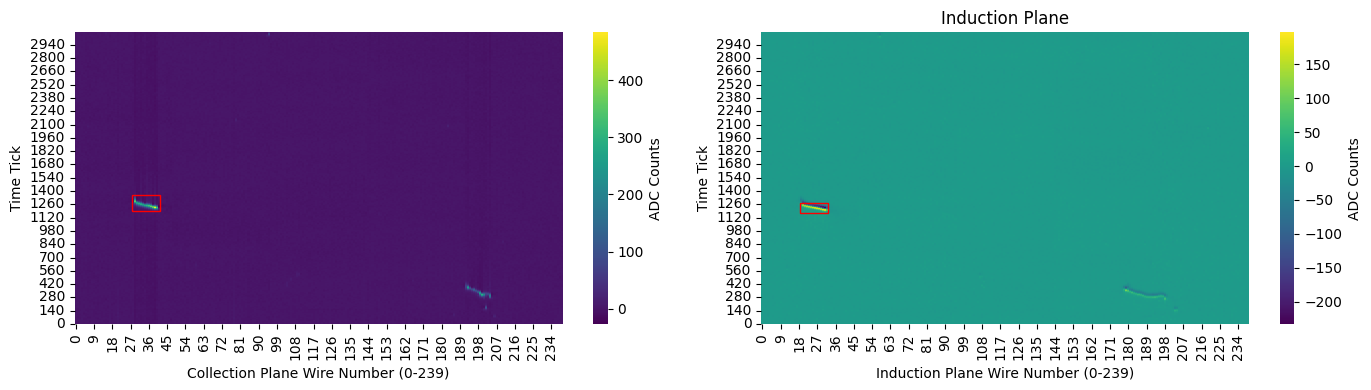

In [177]:
i = 0

row = g.iloc[i]
event = Event(g.iloc[i]['file_path'], index=g.iloc[i]['event_index'], plot=False)

c = event.collection
a = event.induction

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.heatmap(c.T, cmap="viridis", cbar_kws={'label': 'ADC Counts'}, ax=ax1)
ax1.set_xlabel("Collection Plane Wire Number (0-239)")
ax1.set_ylabel("Time Tick")
# ax1.set_title(f"Collection Plane - Beamline Mass: {row['beamline_mass']:.2f}")
ax1.invert_yaxis()

start_wire = row['bbox_min_row'] 
start_time = row['bbox_min_col']
width = row['height']
height = row['width']

rect = Rectangle((start_wire, start_time), 
                    width, height, 
                    linewidth=1, 
                    edgecolor='red', 
                    facecolor='none')
ax1.add_patch(rect)

sns.heatmap(a.T, cmap='viridis', cbar_kws={'label': 'ADC Counts'}, ax=ax2)
ax2.set_xlabel("Induction Plane Wire Number (0-239)")
ax2.set_ylabel("Time Tick")
ax2.set_title("Induction Plane")
ax2.invert_yaxis()

row = g.iloc[i+1]

start_wire = row['bbox_min_row'] 
start_time = row['bbox_min_col']
width = row['height']
height = row['width']

rect = Rectangle((start_wire, start_time), 
                    width, height, 
                    linewidth=1, 
                    edgecolor='red', 
                    facecolor='none')
ax2.add_patch(rect)

plt.tight_layout()  
# plt.savefig(f'/Users/user/data/research/proton-deuteron/findingdeuterons/{i}.png', 
#             dpi=150, bbox_inches='tight')  
# plt.close()  

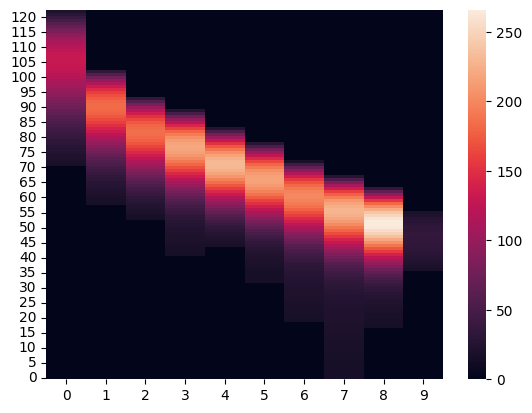

In [28]:
sns.heatmap(row['image_intensity'].T)
plt.gca().invert_yaxis()

In [29]:
c = g.iloc[0]
i = g.iloc[1]

c['max_intensity'], i['max_intensity']

(np.float64(486.0), np.float64(266.0))

In [30]:
print(g['file_path'].iloc[0])

/Users/user/data/research/proton-deuteron/rawdeuterons/deuteron_extracted_root/extracted_lariat_digit_r008689_sr0092_20160527T090805_evtsel_1.root


In [31]:
event_data = g.copy()


csv_data = pd.DataFrame({
    'run': [event_data['run'].iloc[0]],
    'subrun': [event_data['subrun'].iloc[0]],
    'event': [event_data['event'].iloc[0]],
    'c_w_i': [event_data.loc[event_data['plane'] == 'collection', 'bbox_min_row'].values[0]],
    'c_w_f': [event_data.loc[event_data['plane'] == 'collection', 'bbox_max_row'].values[0]],
    'c_t_i': [event_data.loc[event_data['plane'] == 'collection', 'bbox_min_col'].values[0]],
    'c_t_f': [event_data.loc[event_data['plane'] == 'collection', 'bbox_max_col'].values[0]],
    'i_w_i': [event_data.loc[event_data['plane'] == 'induction', 'bbox_min_row'].values[0]],
    'i_w_f': [event_data.loc[event_data['plane'] == 'induction', 'bbox_max_row'].values[0]],
    'i_t_i': [event_data.loc[event_data['plane'] == 'induction', 'bbox_min_col'].values[0]],
    'i_t_f': [event_data.loc[event_data['plane'] == 'induction', 'bbox_max_col'].values[0]]
})

# Save to a CSV file
csv_data.to_csv('/Users/user/data/research/proton-deuteron/bboxReco.csv', index=False)

# Testing Reco Changes

In [32]:
ROOT = '/Users/user/data/research/proton-deuteron/hist_bbox_100a_RecoBBox100A_20250812T181630.root'

In [33]:
f = uproot.open(ROOT)
f.keys(), f.classnames()

(['hitnumfilter;1',
  'hitnumfilter/NumHits_Ind;1',
  'hitnumfilter/NumHits_Col;1',
  'hitnumfilter/NumHits_Ind_pass;1',
  'hitnumfilter/NumHits_Col_pass;1',
  'hitnumfilter/EventPass;1',
  'timestampfilter;1',
  'timestampfilter/Timestamps;1',
  'timestampfilter/Timestamps_pass;1',
  'timestampfilter/EvtCount;1',
  'tof;1',
  'tof/fderhit;1',
  'tof/fdeltaHit;1',
  'tof/fdeltaHitUS;1',
  'tof/fdeltaHitDS;1',
  'tof/fhitAsymmetryUS;1',
  'tof/fhitAsymmetryDS;1',
  'tof/fLenHit;1',
  'tof/fDerUSA;1',
  'tof/fDerUSB;1',
  'tof/fDerDSA;1',
  'tof/fDerDSB;1',
  'tof/fampHitUSA;1',
  'tof/fampHitUSB;1',
  'tof/fampHitDSA;1',
  'tof/fampHitDSB;1',
  'tof/TOF;1',
  'tof/TimeStamp;1',
  'tof/NTOF;1',
  'gaushitOrigin;1',
  'gaushitOrigin/fFirstChi2;1',
  'gaushitOrigin/fChi2;1',
  'toffilter;1',
  'toffilter/TOFBeforeCut;1',
  'trajcluster;1',
  'trajcluster/showervarstree;1',
  'trajclusterOrigin;1',
  'trajclusterOrigin/showervarstree;1',
  'wcquality;1',
  'wcquality/MomOriginal;1',
  'wcqu

In [34]:
t = f['anatree/anatree;1']
t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
subrun               | int32_t                  | AsDtype('>i4')
event                | int32_t                  | AsDtype('>i4')
evttime              | double                   | AsDtype('>f8')
efield               | float                    | AsDtype('>f4')
lifetime             | float                    | AsDtype('>f4')
t0                   | int32_t                  | AsDtype('>i4')
nclus                | int32_t                  | AsDtype('>i4')
clustertwire         | float[]                  | AsJagged(AsDtype('>f4'))
clusterttick         | float[]                  | AsJagged(AsDtype('>f4'))
cluendwire           | float[]                  | AsJagged(AsDtype('>f4'))
cluendtick           | float[]                  | AsJagged(AsDtype('>f4'))
cluplane          

In [35]:
data = t.arrays(['run', 'subrun', 'event', 'trkdedx', 'trkrr', 'hit_dEds'], library='pd'); data

,run,subrun,event,trkdedx,trkrr,hit_dEds
0,8689,92,8362,[[[16.12755584716797 17.432693481445312 15.272...,[[[0.23314125835895538 0.6994237899780273 1.16...,[-999.0 3979.763671875 6248.3388671875 10962.3...


In [36]:
a = data['trkdedx'].values.to_numpy()
b = data['trkrr'].values.to_numpy()

i = np.array(a[0][0][0]) # event, track, plane
irr = np.array(b[0][0][0])
c = np.array(a[0][0][1])
crr = np.array(b[0][0][1])

In [37]:
i = i[i != -99999.0]
irr = irr[irr != -99999.0]

c = c[c != -99999.0]
crr = crr[crr != -99999.0]

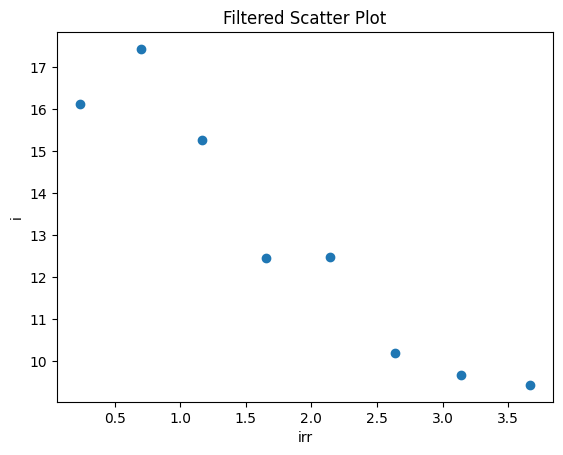

In [38]:
plt.scatter(irr, i)
plt.xlabel("irr")
plt.ylabel("i")
plt.title("Filtered Scatter Plot")
plt.show()

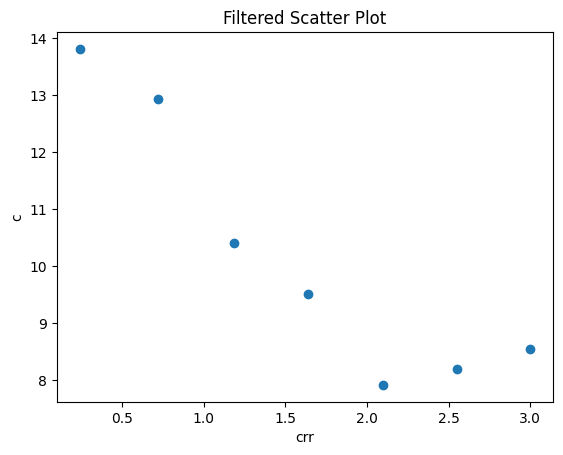

In [39]:
plt.scatter(crr, c)
plt.xlabel("crr")
plt.ylabel("c")
plt.title("Filtered Scatter Plot")
plt.show()

In [40]:
e = data['hit_dEds'].values.to_numpy()
e = np.array(e)

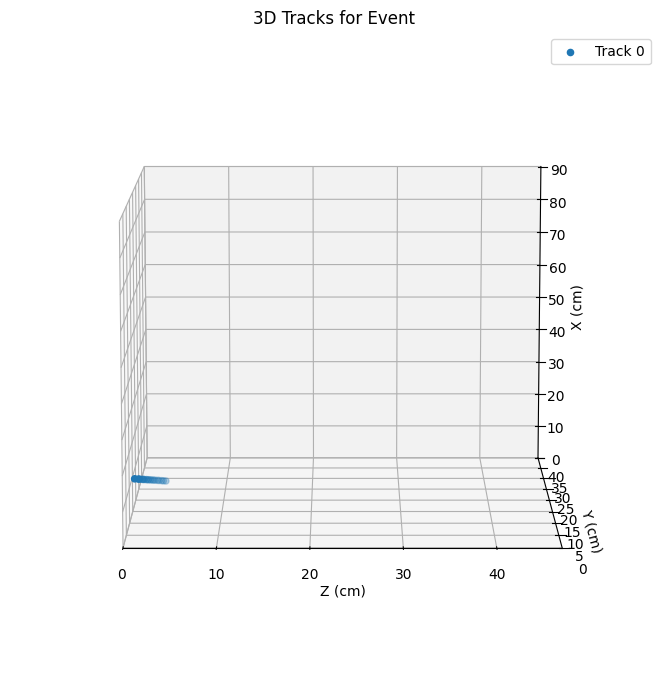

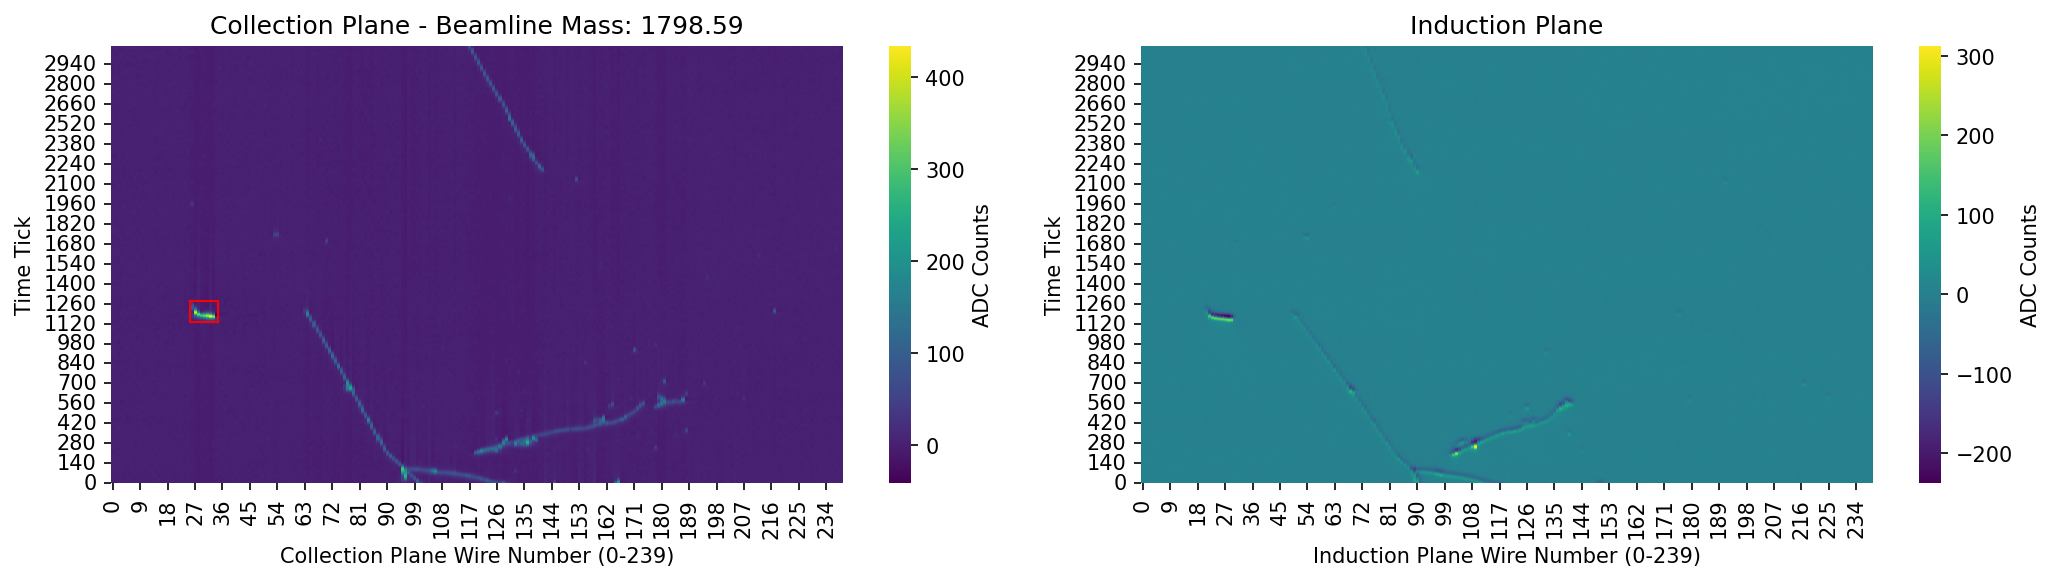

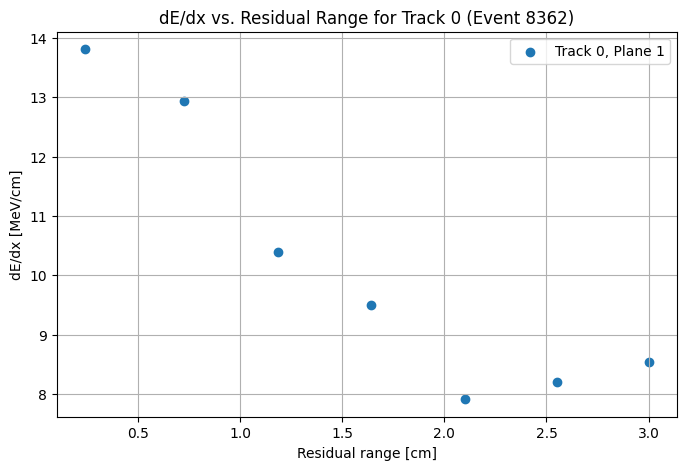

In [41]:
branches = [
    "run", "subrun", "event",

    "nclus", "cluplane",
    "clustertwire", "cluendwire",
    "clusterttick", "cluendtick",
    
    "nhits",
    "hit_plane", "hit_wire", "hit_peakT",
    "hit_trkid",

    "trkdedx", "trkrr", 

    "trkxyz",

    "hit_x", "hit_y", "hit_z",

    "hit_dEds", "hit_resrange"
]

arrays = t.arrays(
    branches,     
    entry_start=0,
    entry_stop=1,
    library     = "ak"
)

# Extract hit data for the event
hit_x = arrays["hit_x"]
hit_y = arrays["hit_y"]
hit_z = arrays["hit_z"]
hit_trkid = arrays["hit_trkid"]

# Get unique track IDs
unique_track_ids = np.unique(hit_trkid)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Iterate over all unique track IDs
for track_id in unique_track_ids:
    if track_id < 0:  # Skip untracked hits
        continue
    
    # Mask hits belonging to the current track
    mask = hit_trkid == track_id
    x = ak.to_numpy(hit_x[mask])
    y = ak.to_numpy(hit_y[mask])
    z = ak.to_numpy(hit_z[mask])
    
    # Plot the track
    ax.scatter(z, y, x, label=f"Track {track_id}")

# Customize the plot
ax.set_xlabel("Z (cm)")
ax.set_ylabel("Y (cm)")
ax.set_zlabel("X (cm)")
ax.set_title(f"3D Tracks for Event")
ax.view_init(elev=10, azim=-90)
ax.set_xlim3d(0, 47); ax.set_ylim3d(0, 40); ax.set_zlim3d(0, 90)
ax.legend()
plt.tight_layout()
plt.show()

import os
from PIL import Image
from IPython.display import display

# Extract run, subrun, and event for the current evt_idx
run = int(arrays["run"][0])
subrun = int(arrays["subrun"][0])
event = int(arrays["event"][0])

# Construct the filename
image_folder = "/Users/user/data/research/proton-deuteron/findingdeuterons/"
image_filename = f"48.png"
image_path = os.path.join(image_folder, image_filename)

# Check if the file exists
if os.path.exists(image_path):
    img = Image.open(image_path)
    display(img)
else:
    print(f"Image file not found: {image_path}")

# Get dE/dx and residual range for the first track in plane 1
trk_idx = 0
plane = 1

dEdx = ak.to_numpy(arrays["trkdedx"][0][trk_idx][plane])
rr   = ak.to_numpy(arrays["trkrr"][0][trk_idx][plane])

mask = (dEdx != -99999) & (rr != -99999)
dEdx_clean = dEdx[mask]
rr_clean = rr[mask]

plt.figure(figsize=(8,5))
plt.scatter(rr_clean, dEdx_clean, marker='o', linestyle='-', label=f'Track {trk_idx}, Plane {plane}')
plt.xlabel("Residual range [cm]")
plt.ylabel("dE/dx [MeV/cm]")
plt.title(f"dE/dx vs. Residual Range for Track {trk_idx} (Event {event})")
plt.legend()
plt.grid(True)
plt.show()